# Sensor Placement - KY 2 Network
Operations Research for Supply Chains I  
ISyE 6333, Fall 2021

## Problem Background
Ensuring the security of critical infrastructures such as water distribution networks is crucial for the welfare and prosperity of our society. Such infrastructure networks may span huge geographical
areas, and are inherently vulnerable to disruptions. In recent years, numerous incidents have been reported that highlight the [inherent vulnerability of infrastructure networks](https://www.scientificamerican.com/article/thousands-of-u-s-areas-afflicted-with-lead-poisoning-beyond-flints/). Operations Research can provide new solutions to help the water utilities to proactively recognize the security risks to their infrastructure, and develop specific capabilities to reduce them.

In this project, a water utility company, and more specifically a network operator, is interested in allocating pressure sensors in order to detect pipe bursts in its water distribution network. The
network is located in Kentucky, and is composed of 1123 pipes and 811 nodes. It provides 2.09 million gallons of water per day to its 5,010 customers. The layout of the water distribution network is given in Figure 1.

The network operator possesses b pressure sensors that they wish to position on nodes of the network in order to detect pipe bursts. We denote $V$ the set of 811 nodes/sensor locations, and $E$ the set of 1123 network pipes. Each node can receive at most one sensor. You will be given a detection matrix, denoted $F ∈ \{0, 1\}^{|E|×|V|}$, that represents the sensing capabilities of the pressure sensors. F is a binary matrix of size $|E| × |V| = 1123 × 811$, and is such that $f_{e,v} = 1$ if a sensor placed at location $v ∈ V$ can detect a burst of pipe $e ∈ E$.

The goal of this project is to determine the optimal location of the b sensors to protect the network as best as possible (we will formalize this notion below).

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb

from pulp import *

import tabulate as tb
import networkx as nx

def get_lx_table(caption, data, headers, precision = ".2f"):
    tbl = []
    tbl.append("\\begin{table}[H]")
    tbl.append("\\centering")
    #latex_tables.append("\\textbf{" + heading + "}")
    tbl.append(tb.tabulate(data, headers=headers, floatfmt= precision, tablefmt="latex_booktabs"))
    tbl.append("\\caption{{ {:s} }}".format(caption))
    tbl.append("\\vspace{10pt}")
    tbl.append("\\end{table}")
    tbl.append("")
    return "\n".join(tbl)

def save_lx_table(filename, caption, data, headers, precision = ".2f"):
    with open(filename, "w") as f:
        f.write(get_lx_table(caption, data, headers, precision))

In [2]:
listSolvers(onlyAvailable=True)

['GUROBI_CMD', 'PULP_CBC_CMD', 'PULP_CHOCO_CMD']

In [3]:
#read in the data
pd_DM = pd.read_csv("Detection_Matrix.csv", header=None)
pd_crit = pd.read_csv("Criticality.csv", names = ['Node'])

print(pd_DM.shape)
print(pd_crit.shape)

(1123, 811)
(1123, 1)


In [4]:
#Set up axis labels for nodes and pipes
pd_DM.set_axis(['N' + str(i).zfill(3) for i in range(len(pd_DM.columns))], axis = 1, inplace=True)
pd_DM.set_axis(['P' + str(i).zfill(4) for i in range(len(pd_DM))], axis = 0, inplace=True)
nodelist = pd_DM.columns
pipelist = pd_DM.index

#Set up labels for criticality dataset
pd_crit.set_axis(['P' + str(i).zfill(4) for i in range(len(pd_crit))], axis = 0, inplace=True)
#Change criticality to 100-based scale
pd_crit_int = (pd_crit['Node'] * 100).apply(lambda x: round(x))

In [5]:
#with pd.option_context("display.max_rows", 1500):
     #display(pd_DM.head(1500))
        
pd_DM.head()

,N000,N001,N002,N003,N004,N005,N006,N007,N008,N009,...,N801,N802,N803,N804,N805,N806,N807,N808,N809,N810
P0000,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P0001,0,1,0,0,0,0,0,1,1,0,...,0,1,1,1,1,0,0,0,0,0
P0002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P0003,0,0,1,1,1,0,0,0,0,1,...,0,1,1,0,0,1,1,1,1,1
P0004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# (A) Detection - Global Maximization
In this first question, it is assumed that each pipe independently bursts with probability 0.1. Formulate an integer program that determines the location of the b sensors that maximizes the expected number of pipe bursts that are detected. Code and solve the optimization model formulated for $b ∈ [\![ 0, 20 ]\!]$ using Gurobi Solver. 

Plot and analyze the optimal value of the problem as a function of the number of sensors $b$. What is the minimum number of sensors to detect all pipe bursts?

In [14]:
# Initialize Problem
problemA = LpProblem("Sensor_Placement", LpMaximize)

#Binary variables denoting if a sensor is placed on a node
node_varsA = LpVariable.dicts("",pd_DM.columns,0,1,cat='Binary')

#Binary variables denoting if a sensor is detecting a pipe
pipe_varsA = LpVariable.dicts("",pd_DM.index,0,1,cat='Binary')

#Objective function - sum of pipes that are detected by a sensor
problemA += lpSum([pipe for pid, pipe in pipe_varsA.items()])

#Linking constraints: pipe binary var >= associated node binary var
for n in nodelist:
    for p in pd_DM[n][pd_DM[n] == 1].index: #find all pipes linked to a node
        problemA += pipe_varsA[p] >= node_varsA[n] # setup a constraint for each pipe-node combination
        
#Linking constraints: making sure that p is zero if none of the nodes have sensors
for p in pipelist: #for each pipe
    all_rel_nodes = pd_DM.loc[p][pd_DM.loc[p] == 1].index #find all nodes touching a pipe
    problemA += pipe_varsA[p] <= lpSum([node_varsA[n] for n in all_rel_nodes]) #ensure the constraint

In [15]:
backup_problemA = copy.deepcopy(problemA)

In [16]:
df_listA = []

for limit in range(1,21):
    problemA = copy.deepcopy(backup_problemA)
    problemA += lpSum([node_varsA[n] for n in nodelist]) <= limit
    
    problemA.solve(GUROBI_CMD(msg=False))
    
    opt = LpStatus[problemA.status]
    of_val = value(problemA.objective)
    np_list = []
    for j, i in node_varsA.items():
        if i.varValue != 0:
            np_list.append(i.name)
    
    print('Max_Sensors: {}, Status: {}, Objective_Fun: {}, Expected_Bursts: {}'.format(limit, opt, of_val, of_val/10))
    print('Nodes Placed: {}'.format(np_list))
    df_listA.append(pd.DataFrame([[limit, opt, of_val, of_val/10, np_list]], 
                                columns = ['Max_Sensors', 'Status', 'Objective_Fun', 'Expected_Bursts', 'Nodes_Placed']))

Max_Sensors: 1, Status: Optimal, Objective_Fun: 391.0, Expected_Bursts: 39.1
Nodes Placed: ['_N036']
Max_Sensors: 2, Status: Optimal, Objective_Fun: 582.0, Expected_Bursts: 58.2
Nodes Placed: ['_N042', '_N614']
Max_Sensors: 3, Status: Optimal, Objective_Fun: 740.0, Expected_Bursts: 74.0
Nodes Placed: ['_N140', '_N614', '_N690']
Max_Sensors: 4, Status: Optimal, Objective_Fun: 839.0, Expected_Bursts: 83.9
Nodes Placed: ['_N237', '_N614', '_N690', '_N764']
Max_Sensors: 5, Status: Optimal, Objective_Fun: 907.0, Expected_Bursts: 90.7
Nodes Placed: ['_N140', '_N237', '_N646', '_N690', '_N712']
Max_Sensors: 6, Status: Optimal, Objective_Fun: 965.0, Expected_Bursts: 96.5
Nodes Placed: ['_N067', '_N287', '_N451', '_N591', '_N595', '_N722']
Max_Sensors: 7, Status: Optimal, Objective_Fun: 1000.0, Expected_Bursts: 100.0
Nodes Placed: ['_N067', '_N206', '_N451', '_N591', '_N619', '_N712', '_N775']
Max_Sensors: 8, Status: Optimal, Objective_Fun: 1034.0, Expected_Bursts: 103.4
Nodes Placed: ['_N003',

In [17]:
resultsA = pd.concat(df_listA).reset_index(drop=True)
display(resultsA)

,Max_Sensors,Status,Objective_Fun,Expected_Bursts,Nodes_Placed
0,1,Optimal,391.0,39.1,[_N036]
1,2,Optimal,582.0,58.2,"[_N042, _N614]"
2,3,Optimal,740.0,74.0,"[_N140, _N614, _N690]"
3,4,Optimal,839.0,83.9,"[_N237, _N614, _N690, _N764]"
4,5,Optimal,907.0,90.7,"[_N140, _N237, _N646, _N690, _N712]"
5,6,Optimal,965.0,96.5,"[_N067, _N287, _N451, _N591, _N595, _N722]"
6,7,Optimal,1000.0,100.0,"[_N067, _N206, _N451, _N591, _N619, _N712, _N775]"
7,8,Optimal,1034.0,103.4,"[_N003, _N067, _N103, _N206, _N450, _N591, _N6..."
8,9,Optimal,1056.0,105.6,"[_N034, _N067, _N103, _N206, _N233, _N619, _N6..."
9,10,Optimal,1071.0,107.1,"[_N103, _N206, _N240, _N267, _N344, _N439, _N6..."


In [18]:
save_lx_table("Problem A placement.tex", "Sensor placement", resultsA.drop(["Status"], axis=1), resultsA.drop(["Status"], axis=1).columns)

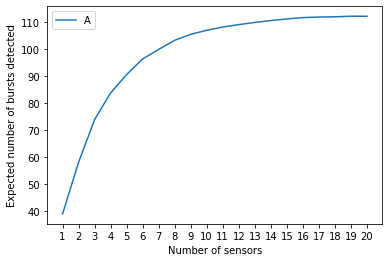

In [19]:
grid = sb.lineplot(x=resultsA.Max_Sensors, y=resultsA.Expected_Bursts, label="A")
grid.set(xlabel="Number of sensors", ylabel="Expected number of bursts detected")
#plt.title("Burst detection performance as a function of sensors placed")
grid.set_xticks(range(1,21))
grid.set_xticklabels(range(1,21))
plt.savefig("Problem A chart.png")
plt.show()

# (B) Detection - Greedy Algorithm
Instead, the operator wants to investigate a faster solution approach, where sensor locations are sequentially (and myopically) selected. Specifically, the operator takes their first sensor, and places it at the node that detects the maximum expected number of pipe bursts. Then, they take the second sensor, and places it at the node that detects the maximum expected number of pipe bursts that were not previously detected, and so on until all sensors are positioned.

Code this iterative algorithm, and plot the resulting expected number of pipe bursts that are detected by that solution, as a function of the number of sensors available, $b ∈ [\![ 0, 20 ]\!]$. Compare this plot with the one obtained in part **(A)**.

In [20]:
df_listC = []
selected_nodesC = set()

for limit in range(1,21):
    problemA = copy.deepcopy(backup_problemA)
    problemA += lpSum([node_varsA[n] for n in nodelist]) <= limit
    
    if len(selected_nodesC) > 0:
        for n in selected_nodesC:
            problemA += node_varsA[n] == 1
    problemA.solve(GUROBI_CMD(msg=False))
    
    opt = LpStatus[problemA.status]
    of_val = value(problemA.objective)
    np_list = []
    for j, i in node_varsA.items():
        if i.varValue != 0:
            np_list.append(i.name)
            selected_nodesC.update({i.name[1:]})
    
    print('Max_Sensors: {}, Status: {}, Objective_Fun: {}, Expected_Bursts: {}'.format(limit, opt, of_val, of_val/10))
    print('Nodes Placed: {}'.format(np_list))
    df_listC.append(pd.DataFrame([[limit, opt, of_val, of_val/10, np_list]], 
                                columns = ['Max_Sensors', 'Status', 'Objective_Fun', 'Expected_Bursts', 'Nodes_Placed']))

Max_Sensors: 1, Status: Optimal, Objective_Fun: 391.0, Expected_Bursts: 39.1
Nodes Placed: ['_N036']
Max_Sensors: 2, Status: Optimal, Objective_Fun: 562.0, Expected_Bursts: 56.2
Nodes Placed: ['_N036', '_N614']
Max_Sensors: 3, Status: Optimal, Objective_Fun: 729.0, Expected_Bursts: 72.9
Nodes Placed: ['_N024', '_N036', '_N614']
Max_Sensors: 4, Status: Optimal, Objective_Fun: 805.0, Expected_Bursts: 80.5
Nodes Placed: ['_N024', '_N036', '_N303', '_N614']
Max_Sensors: 5, Status: Optimal, Objective_Fun: 864.0, Expected_Bursts: 86.4
Nodes Placed: ['_N024', '_N036', '_N177', '_N303', '_N614']
Max_Sensors: 6, Status: Optimal, Objective_Fun: 918.0, Expected_Bursts: 91.8
Nodes Placed: ['_N024', '_N036', '_N177', '_N303', '_N614', '_N712']
Max_Sensors: 7, Status: Optimal, Objective_Fun: 960.0, Expected_Bursts: 96.0
Nodes Placed: ['_N024', '_N036', '_N177', '_N287', '_N303', '_N614', '_N712']
Max_Sensors: 8, Status: Optimal, Objective_Fun: 994.0, Expected_Bursts: 99.4
Nodes Placed: ['_N024', '_N

In [21]:
resultsC = pd.concat(df_listC).reset_index(drop=True)

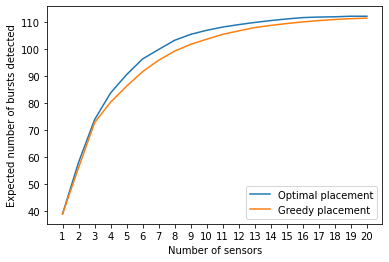

In [22]:
#plt.plot(resultsA.Max_Sensors, resultsA.Expected_Bursts, label = 'A')
#plt.plot(resultsC.Max_Sensors, resultsC.Expected_Bursts, label = 'C')
#plt.legend()

grid = sb.lineplot(x=resultsA.Max_Sensors, y=resultsA.Expected_Bursts, label="Optimal placement")
grid.set(xlabel="Number of sensors", ylabel="Expected number of bursts detected")
grid.set_xticks(range(1,21))
grid.set_xticklabels(range(1,21))
sb.lineplot(x=resultsC.Max_Sensors, y=resultsC.Expected_Bursts, label="Greedy placement")
#plt.title("Burst detection performance as a function of sensors placed")
plt.savefig("Problem C chart.png")
plt.show()

# (C) Unmonitored Criticality - Minimize the Maximum Criticality of an Unmonitored Pipe
It turns out that some pipes are more critical than others, depending on their locations. For example, a pipe burst next to a hospital will be more problematic than a pipe burst in a remote area. Each pipe $e ∈ E$ is assigned a criticality level $w_e ∈ [0, 1]$. The higher we is, the more critical pipe $e$ is. The goal of the network operator is to position their $b$ sensors as to minimize the highest criticality of a pipe that is not detected by any sensor. Formulate this problem as an IP.

Code and solve the optimization model formulated for $b ∈ [\![ 0, 20 ]\!]$ using Gurobi Solver. Plot and analyze the optimal value of the problem as a function of the number of sensors $b$.

In [23]:
# Initialize Variables
node_varsE = LpVariable.dicts("",pd_DM.columns,0,1,cat='Binary')
pipe_varsE = LpVariable.dicts("",pd_DM.index,0,1,cat='Binary')
constraint_varsE = LpVariable.dicts("const_",pd_DM.index,0,1,cat='Binary')
auxz = LpVariable("Z")

#Min Max problem: Min Z
problemE = LpProblem("Sensor_Placement", LpMinimize)
problemE += auxz #that's the objective

#Subject to z + yiwi >= (1 - xi) * wi where xi is a detected pipe and wi is its criticality
# z >= (1 - xi) * wi - yiwi
for pid, pipe in pipe_varsE.items():
    problemE += auxz >= (1 - pipe) * pd_crit_int[pid]

#Here, every pipe binary var is given a criticality weight and we optimize weighted sum
#problemE = LpProblem("Sensor_Placement", LpMaximize)
#problemE += lpSum([pipe * pd_crit_int[pid] for pid, pipe in pipe_varsE.items()])

# + Same constraints as before
for n in nodelist:
    for p in pd_DM[n][pd_DM[n] == 1].index:
        problemE += pipe_varsE[p] >= node_varsE[n]
        
for p in pipelist:
    problemE += pipe_varsE[p] <= lpSum([node_varsE[n] 
                 for n in pd_DM.loc[p][pd_DM.loc[p] == 1].index])

In [24]:
backup_problemE = copy.deepcopy(problemE)

In [25]:
df_listE = []

#Finding affected pipes
def get_affected_pipes(np_list):
    nodes = [n[1:] for n in np_list]    
    affected_pipes = pd_DM.loc[:,nodes].apply(lambda x: sum(x), axis=1)
    return (len(affected_pipes[affected_pipes > 0].index), pd_crit.loc[affected_pipes[affected_pipes > 0].index, "Node"].mean())    

for limit in range(1, 21):
    problemE = copy.deepcopy(backup_problemE)    
    problemE += lpSum([node_varsE[n] for n in nodelist]) == limit
    
    problemE.solve(GUROBI_CMD(msg=False))
    
    opt = LpStatus[problemE.status]
    of_val = value(problemE.objective)
    np_list = []
    for j, i in node_varsE.items():
        if i.varValue != 0:
            np_list.append(i.name)
    
    print('Max_Sensors: {}, Status: {}, Objective_Fun: {}, Expected_Bursts: {}'.format(limit, opt, of_val, of_val/10))
    print('Nodes Placed: {}'.format(np_list))
    no_pipes, avg_crit = get_affected_pipes(np_list)
    print('Pipes covered: {}'.format(no_pipes))
    print('Avg criticality covered: {}'.format(avg_crit))
    df_listE.append(pd.DataFrame([[limit, opt, of_val, no_pipes, avg_crit, np_list]], 
                                columns = ['Max_Sensors', 'Status', 'Objective_Fun', 'Pipes covered', "Avg criticality covered", 'Nodes_Placed']))

Max_Sensors: 1, Status: Optimal, Objective_Fun: 100.0, Expected_Bursts: 10.0
Nodes Placed: ['_N729']
Pipes covered: 0
Avg criticality covered: nan
Max_Sensors: 2, Status: Optimal, Objective_Fun: 100.0, Expected_Bursts: 10.0
Nodes Placed: ['_N660', '_N729']
Pipes covered: 2
Avg criticality covered: 0.7
Max_Sensors: 3, Status: Optimal, Objective_Fun: 100.0, Expected_Bursts: 10.0
Nodes Placed: ['_N000', '_N660', '_N729']
Pipes covered: 10
Avg criticality covered: 0.5110000000000001
Max_Sensors: 4, Status: Optimal, Objective_Fun: 99.0, Expected_Bursts: 9.9
Nodes Placed: ['_N061', '_N199', '_N215', '_N756']
Pipes covered: 709
Avg criticality covered: 0.4954724964739074
Max_Sensors: 5, Status: Optimal, Objective_Fun: 99.0, Expected_Bursts: 9.9
Nodes Placed: ['_N215', '_N325', '_N460', '_N585', '_N699']
Pipes covered: 738
Avg criticality covered: 0.4950406504065044
Max_Sensors: 6, Status: Optimal, Objective_Fun: 97.0, Expected_Bursts: 9.7
Nodes Placed: ['_N014', '_N103', '_N128', '_N207', '_N

In [26]:
resultsE = pd.concat(df_listE).reset_index(drop=True)

In [27]:
# pd_DM.sum(axis = 0).sort_values(ascending = False)[:10].sort_index()

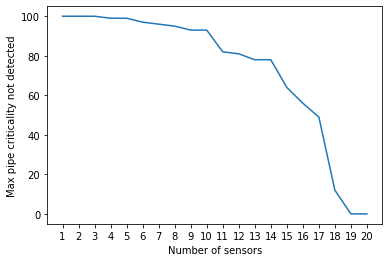

In [28]:
grid = sb.lineplot(x=resultsE.Max_Sensors, y=resultsE.Objective_Fun)
grid.set(xlabel="Number of sensors", ylabel="Max pipe criticality not detected")
#plt.title("Burst detection performance as a function of sensors placed")
grid.set_xticks(range(1,21))
grid.set_xticklabels(range(1,21))
plt.savefig("Problem E chart.png")
plt.show()

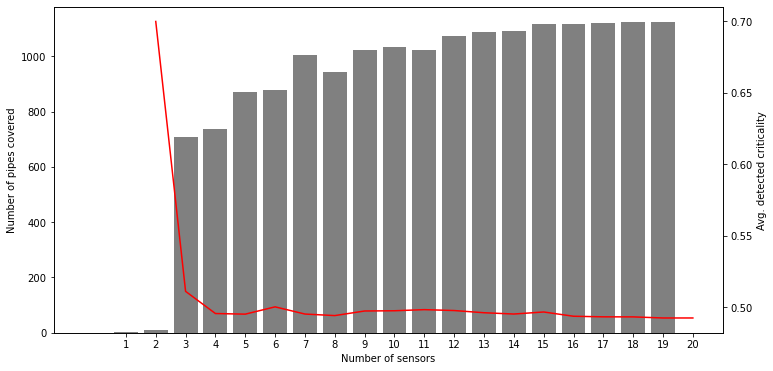

In [29]:
fig, ax1 = plt.subplots(figsize=(12,6))
grid = sb.barplot(x=resultsE.Max_Sensors, y=resultsE['Pipes covered'], ax=ax1, color="grey")
grid.set(xlabel="Number of sensors", ylabel="Number of pipes covered")
ax2 = ax1.twinx()
grid = sb.lineplot(x=resultsE.Max_Sensors, y=resultsE['Avg criticality covered'], ax=ax2, color="red")
grid.set(xlabel="Number of sensors", ylabel="Avg. detected criticality")
#plt.title("Burst detection performance as a function of sensors placed")
grid.set_xticks(range(1,21))
grid.set_xticklabels(range(1,21))
plt.savefig("Problem E chart - pipe_choice.png")
plt.show()

# (D) Unmonitored Criticality - Minimize the Average Criticality of all Unmonitored Pipes

In [30]:
# Initialize Variables
node_varsEU = LpVariable.dicts("",pd_DM.columns,0,1,cat='Binary')
pipe_varsEU = LpVariable.dicts("",pd_DM.index,0,1,cat='Binary')
constraint_varsEU = LpVariable.dicts("const_",pd_DM.index,0,1,cat='Binary')
auxz = LpVariable("Z")

#Min Max problem: Min Z
problemEU = LpProblem("Sensor_Placement", LpMinimize)
problemEU += auxz - lpSum([pipe * pd_crit_int[pid]/100 for pid, pipe in pipe_varsEU.items()]) / 1123  #that's the objective

#Subject to z + yiwi >= (1 - xi) * wi where xi is a detected pipe and wi is its criticality
# z >= (1 - xi) * wi - yiwi
for pid, pipe in pipe_varsEU.items():
    problemEU += auxz >= (1 - pipe) * pd_crit_int[pid]

#Here, every pipe binary var is given a criticality weight and we optimize weighted sum
#problemE = LpProblem("Sensor_Placement", LpMaximize)
#problemE += lpSum([pipe * pd_crit_int[pid] for pid, pipe in pipe_varsE.items()])

# + Same constraints as before
for n in nodelist:
    for p in pd_DM[n][pd_DM[n] == 1].index:
        problemEU += pipe_varsEU[p] >= node_varsEU[n]
        
for p in pipelist:
    problemEU += pipe_varsEU[p] <= lpSum([node_varsEU[n] 
                 for n in pd_DM.loc[p][pd_DM.loc[p] == 1].index])

In [31]:
backup_problemEU = copy.deepcopy(problemEU)
df_listEU = []

#Finding affected pipes
def get_affected_pipes(np_list):
    nodes = [n[1:] for n in np_list]    
    affected_pipes = pd_DM.loc[:,nodes].apply(lambda x: sum(x), axis=1)
    return (len(affected_pipes[affected_pipes > 0].index), pd_crit.loc[affected_pipes[affected_pipes > 0].index, "Node"].mean())    

for limit in range(1, 21):
    problemEU = copy.deepcopy(backup_problemEU)    
    problemEU += lpSum([node_varsEU[n] for n in nodelist]) == limit
    
    problemEU.solve(GUROBI_CMD(msg=False))
    
    opt = LpStatus[problemEU.status]
    of_val = value(problemEU.objective)
    np_list = []
    for j, i in node_varsEU.items():
        if i.varValue != 0:
            np_list.append(i.name)
    
    print('Max_Sensors: {}, Status: {}, Objective_Fun: {}'.format(limit, opt, of_val))
    print('Nodes Placed: {}'.format(np_list))
    no_pipes, avg_crit = get_affected_pipes(np_list)
    print('Pipes covered: {}'.format(no_pipes))
    print('Avg criticality covered: {}'.format(avg_crit))
    df_listEU.append(pd.DataFrame([[limit, opt, of_val, no_pipes, avg_crit, np_list]], 
                                columns = ['Max_Sensors', 'Status', 'Objective_Fun', 'Pipes covered', "Avg criticality covered", 'Nodes_Placed']))

Max_Sensors: 1, Status: Optimal, Objective_Fun: 99.82934995547642
Nodes Placed: ['_N036']
Pipes covered: 391
Avg criticality covered: 0.4901278772378515
Max_Sensors: 2, Status: Optimal, Objective_Fun: 99.74664292074797
Nodes Placed: ['_N042', '_N614']
Pipes covered: 582
Avg criticality covered: 0.48886597938144344
Max_Sensors: 3, Status: Optimal, Objective_Fun: 99.67711487088151
Nodes Placed: ['_N024', '_N041', '_N129']
Pipes covered: 732
Avg criticality covered: 0.49535519125683103
Max_Sensors: 4, Status: Optimal, Objective_Fun: 98.66349955476403
Nodes Placed: ['_N207', '_N477', '_N585', '_N690']
Pipes covered: 762
Avg criticality covered: 0.4959186351706042
Max_Sensors: 5, Status: Optimal, Objective_Fun: 98.60813891362423
Nodes Placed: ['_N024', '_N207', '_N287', '_N471', '_N756']
Pipes covered: 882
Avg criticality covered: 0.4989342403628123
Max_Sensors: 6, Status: Optimal, Objective_Fun: 96.60097061442566
Nodes Placed: ['_N014', '_N024', '_N103', '_N207', '_N287', '_N595']
Pipes co

In [32]:
resultsEU = pd.concat(df_listEU).reset_index(drop=True)

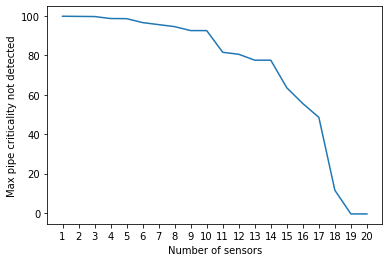

In [33]:
grid = sb.lineplot(x=resultsEU.Max_Sensors, y=resultsEU.Objective_Fun)
grid.set(xlabel="Number of sensors", ylabel="Max pipe criticality not detected")
#plt.title("Burst detection performance as a function of sensors placed")
grid.set_xticks(range(1,21))
grid.set_xticklabels(range(1,21))
plt.savefig("Problem EU chart.png")
plt.show()

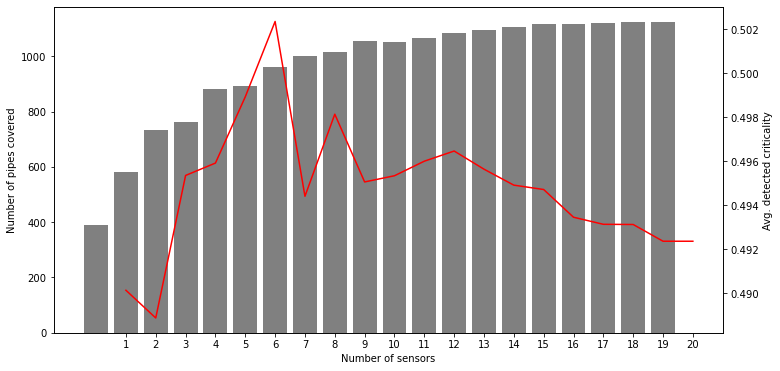

In [34]:
fig, ax1 = plt.subplots(figsize=(12,6))
grid = sb.barplot(x=resultsEU.Max_Sensors, y=resultsEU['Pipes covered'], ax=ax1, color="grey")
grid.set(xlabel="Number of sensors", ylabel="Number of pipes covered")
ax2 = ax1.twinx()
grid = sb.lineplot(x=resultsEU.Max_Sensors, y=resultsEU['Avg criticality covered'], ax=ax2, color="red")
grid.set(xlabel="Number of sensors", ylabel="Avg. detected criticality")
#plt.title("Burst detection performance as a function of sensors placed")
grid.set_xticks(range(1,21))
grid.set_xticklabels(range(1,21))
plt.savefig("Problem EU chart - pipe_choice.png")
plt.show()